# < Simple RNN >
- Data  : Kaggle_

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

url = 'https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv'

In [2]:
df = pd.read_csv(url, encoding = 'latin1')
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


## 1.데이터 전처리

In [3]:
# Selection : v1, v2
df = df[['v1', 'v2']]

In [4]:
# null check
df.isna().sum()

v1    0
v2    0
dtype: int64

In [5]:
# duplicate check
df.shape, df.v2.nunique()

((5572, 2), 5169)

In [6]:
df.drop_duplicates(subset = ['v2'], inplace = True)
df.shape

(5169, 2)

In [7]:
# ['ham', 'spam'] => [0, 1]
df.v1 = df.v1.replace(['ham', 'spam'], [0, 1])
df.head(3)

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [8]:
# Ham / spam 분포
df.v1.value_counts()

0    4516
1     653
Name: v1, dtype: int64

In [9]:
# 전처리 완료 데이터 저장
df.to_csv('Ham_Spam.csv', index = False)

In [10]:
x, y = df.v2.values, df.v1.values
x.shape, y.shape

((5169,), (5169,))

### 1.2.Keras Text Preprocessing

#### 1.2.1.preprocessing함수 생성(re.sub)

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
import re
def preprocessing(text):
    text = text.encode('utf8').decode('ascii', 'ignore')
    text = re.sub('[^A-Za-z0-9 ]', '', text)
    return text.lower()

In [13]:
x[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [14]:
X_data = [preprocessing(line) for line in x]
X_data[2]

'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s'

#### 1.2.2.단어집합 생성 및 크기 확인

In [15]:
token = Tokenizer()
token.fit_on_texts(X_data) 

In [16]:
# 단어 집합 크기
vocab_size = len(token.word_index) + 1      # 0때문에 1을 더해줘야 됨.
vocab_size

9479

## 2.Sequences 생성

In [17]:
sequences = token.texts_to_sequences(X_data)
print(sequences[2])

[54, 508, 8, 22, 4, 959, 960, 2, 217, 2566, 1291, 664, 2567, 2568, 268, 2569, 71, 2566, 2, 2570, 2, 336, 508, 3839, 84, 3840, 424, 3841]


In [18]:
max_len = max(len(seq) for seq in sequences)
max_len

171

In [19]:
# 전체 seq를 Max_len 길이에 맞게 0을 padding함
data = pad_sequences(sequences, maxlen = max_len)

## 3.train/test set 분리

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, y, stratify = y, test_size = 0.2, random_state = 2022
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4135, 171), (1034, 171), (4135,), (1034,))

## 4.모델 설정 및 평가

In [21]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [37]:
model = Sequential([
    Embedding(vocab_size, 32, input_length=max_len),
    SimpleRNN(32),
    Dense(1, activation = 'sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 171, 32)           303328    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 305,441
Trainable params: 305,441
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile('adam', 'binary_crossentropy', ['accuracy'])

In [40]:
model_path = 'best-spam-rnn.h5'
mc = ModelCheckpoint(model_path, verbose = 1, save_best_only=True)
es = EarlyStopping(patience = 15)

In [41]:
hist = model.fit(X_train, y_train, validation_split = 0.2,
                 epochs = 100, batch_size = 64, callbacks = [mc, es])

Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 0.4228 - accuracy: 0.8464
Epoch 1: val_loss improved from inf to 0.32299, saving model to best-spam-rnn.h5
52/52 [==============================] - 8s 100ms/step - loss: 0.4228 - accuracy: 0.8464 - val_loss: 0.3230 - val_accuracy: 0.8948
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 0.2953 - accuracy: 0.9045
Epoch 2: val_loss improved from 0.32299 to 0.20887, saving model to best-spam-rnn.h5
52/52 [==============================] - 5s 92ms/step - loss: 0.2953 - accuracy: 0.9045 - val_loss: 0.2089 - val_accuracy: 0.9553
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 0.1188 - accuracy: 0.9770
Epoch 3: val_loss improved from 0.20887 to 0.11021, saving model to best-spam-rnn.h5
52/52 [==============================] - 5s 96ms/step - loss: 0.1188 - accuracy: 0.9770 - val_loss: 0.1102 - val_accuracy: 0.9722
Epoch 4/100
52/52 [==============================] - ETA: 0s - loss: 0.05

In [42]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

33/33 [==============================] - 1s 21ms/step - loss: 0.0751 - accuracy: 0.9787


[0.07514862716197968, 0.978723406791687]

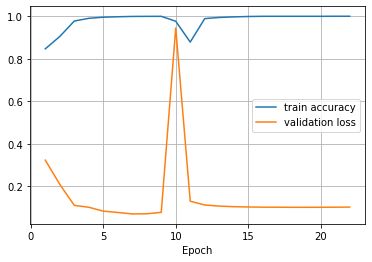

In [44]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend(), plt.grid()
plt.xlabel('Epoch')
plt.show()

### 4.1.accuracy 대신 recall - 78.62
- 실제 스팸중 모델이 스팸이라고 예측한 비율
    - 모델이 스팸이라고 예측했는데 실제 스팸인(accuracy)와 다름

In [22]:
from tensorflow.keras.metrics import Recall, Precision

In [53]:
model.compile('adam', 'binary_crossentropy', Recall(name='recall'))

In [54]:
model_path = 'best-spam-rnn-recall.h5'
mc = ModelCheckpoint(model_path, verbose = 1, save_best_only=True)
es = EarlyStopping(patience = 15)

In [55]:
hist = model.fit(X_train, y_train, validation_split = 0.2,
                 epochs = 100, batch_size = 64, callbacks = [mc, es])

Epoch 1/100
51/52 [============================>.] - ETA: 0s - loss: 0.0022 - recall: 1.0000
Epoch 1: val_loss improved from inf to 0.10516, saving model to best-spam-rnn-recall.h5
52/52 [==============================] - 4s 57ms/step - loss: 0.0022 - recall: 1.0000 - val_loss: 0.1052 - val_recall: 0.7471
Epoch 2/100
51/52 [============================>.] - ETA: 0s - loss: 6.9473e-04 - recall: 1.0000
Epoch 2: val_loss did not improve from 0.10516
52/52 [==============================] - 3s 50ms/step - loss: 6.9400e-04 - recall: 1.0000 - val_loss: 0.1164 - val_recall: 0.7931
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 3.4146e-04 - recall: 1.0000
Epoch 3: val_loss did not improve from 0.10516
52/52 [==============================] - 3s 50ms/step - loss: 3.4146e-04 - recall: 1.0000 - val_loss: 0.1354 - val_recall: 0.7126
Epoch 4/100
52/52 [==============================] - ETA: 0s - loss: 1.8578e-04 - recall: 1.0000
Epoch 4: val_loss improved from 0.10516 to 0.099

In [56]:
best_model_recall = load_model(model_path)
best_model_recall.evaluate(X_test, y_test)

33/33 [==============================] - 1s 12ms/step - loss: 0.1231 - recall: 0.7863


[0.1230911985039711, 0.7862595319747925]

## 4.1 LSTM(32) - 89.31

In [24]:
from tensorflow.keras.layers import LSTM, GRU

In [58]:
model2 = Sequential([
    Embedding(vocab_size, 32, input_length=max_len),
    LSTM(32),
    Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 171, 32)           303328    
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 311,681
Trainable params: 311,681
Non-trainable params: 0
_________________________________________________________________


In [59]:
model_path2 = 'best-spam-rnn_v2.h5'
mc = ModelCheckpoint(model_path2, verbose = 1, save_best_only=True)
es = EarlyStopping(patience = 15)

In [61]:
model2.compile('adam', 'binary_crossentropy', Recall(name='recall'))

In [62]:
hist2 = model2.fit(X_train, y_train, validation_split = 0.2,
                 epochs = 100, batch_size = 64, callbacks = [mc, es])

Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 0.4379 - recall: 0.0184
Epoch 1: val_loss improved from inf to 0.24118, saving model to best-spam-rnn_v2.h5
52/52 [==============================] - 9s 114ms/step - loss: 0.4379 - recall: 0.0184 - val_loss: 0.2412 - val_recall: 0.0000e+00
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 0.1462 - recall: 0.6253
Epoch 2: val_loss improved from 0.24118 to 0.08914, saving model to best-spam-rnn_v2.h5
52/52 [==============================] - 5s 103ms/step - loss: 0.1462 - recall: 0.6253 - val_loss: 0.0891 - val_recall: 0.8506
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 0.0616 - recall: 0.9172
Epoch 3: val_loss improved from 0.08914 to 0.08184, saving model to best-spam-rnn_v2.h5
52/52 [==============================] - 5s 103ms/step - loss: 0.0616 - recall: 0.9172 - val_loss: 0.0818 - val_recall: 0.8391
Epoch 4/100
52/52 [==============================] - ETA: 0s - loss: 0.0362 

In [63]:
best_model2 = load_model(model_path2)
best_model2.evaluate(X_test, y_test)

33/33 [==============================] - 1s 18ms/step - loss: 0.0650 - recall: 0.8931


[0.06499695032835007, 0.8931297659873962]

## 4.2 LSTM(32-64) - 89.31

In [65]:
model3 = Sequential([
    Embedding(vocab_size, 32, input_length=max_len),
    LSTM(64),
    Dense(1, activation = 'sigmoid')
])
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 171, 32)           303328    
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 328,225
Trainable params: 328,225
Non-trainable params: 0
_________________________________________________________________


In [66]:
model_path3 = 'best-spam-rnn_v3.h5'
mc = ModelCheckpoint(model_path3, verbose = 1, save_best_only=True)
es = EarlyStopping(patience = 15)

In [67]:
model3.compile('adam', 'binary_crossentropy', Recall(name='recall'))

In [68]:
hist3 = model3.fit(X_train, y_train, validation_split = 0.2,
                 epochs = 100, batch_size = 64, callbacks = [mc, es])

Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 0.4076 - recall: 0.0184
Epoch 1: val_loss improved from inf to 0.19376, saving model to best-spam-rnn_v3.h5
52/52 [==============================] - 16s 236ms/step - loss: 0.4076 - recall: 0.0184 - val_loss: 0.1938 - val_recall: 0.1839
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 0.1188 - recall: 0.7540
Epoch 2: val_loss improved from 0.19376 to 0.09724, saving model to best-spam-rnn_v3.h5
52/52 [==============================] - 9s 175ms/step - loss: 0.1188 - recall: 0.7540 - val_loss: 0.0972 - val_recall: 0.7241
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 0.0415 - recall: 0.9379
Epoch 3: val_loss improved from 0.09724 to 0.07143, saving model to best-spam-rnn_v3.h5
52/52 [==============================] - 9s 178ms/step - loss: 0.0415 - recall: 0.9379 - val_loss: 0.0714 - val_recall: 0.8736
Epoch 4/100
52/52 [==============================] - ETA: 0s - loss: 0.0208 - r

In [69]:
best_model3 = load_model(model_path3)
best_model3.evaluate(X_test, y_test)

33/33 [==============================] - 2s 25ms/step - loss: 0.0596 - recall: 0.8931


[0.059578437358140945, 0.8931297659873962]

## 4.3 LSTM(64-64)  - 90.07

In [25]:
model4 = Sequential([
    Embedding(vocab_size, 64, input_length=max_len),
    LSTM(64),
    Dense(1, activation = 'sigmoid')
])
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 171, 64)           606656    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 639,745
Trainable params: 639,745
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_path4 = 'best-spam-rnn_v4.h5'
mc = ModelCheckpoint(model_path4, verbose = 1, save_best_only=True)
es = EarlyStopping(patience = 15)

In [27]:
model4.compile('adam', 'binary_crossentropy', Recall(name='recall'))

In [28]:
hist4 = model4.fit(X_train, y_train, validation_split = 0.2,
                 epochs = 100, batch_size = 64, callbacks = [mc, es])

Epoch 1/100
50/52 [===========================>..] - ETA: 0s - loss: 0.3774 - recall: 0.0786
Epoch 1: val_loss improved from inf to 0.13627, saving model to best-spam-rnn_v4.h5
52/52 [==============================] - 9s 26ms/step - loss: 0.3727 - recall: 0.0828 - val_loss: 0.1363 - val_recall: 0.6667
Epoch 2/100
50/52 [===========================>..] - ETA: 0s - loss: 0.0866 - recall: 0.8753
Epoch 2: val_loss improved from 0.13627 to 0.07395, saving model to best-spam-rnn_v4.h5
52/52 [==============================] - 1s 14ms/step - loss: 0.0856 - recall: 0.8759 - val_loss: 0.0739 - val_recall: 0.7816
Epoch 3/100
51/52 [============================>.] - ETA: 0s - loss: 0.0298 - recall: 0.9674
Epoch 3: val_loss improved from 0.07395 to 0.07088, saving model to best-spam-rnn_v4.h5
52/52 [==============================] - 1s 14ms/step - loss: 0.0296 - recall: 0.9678 - val_loss: 0.0709 - val_recall: 0.8966
Epoch 4/100
48/52 [==========================>...] - ETA: 0s - loss: 0.0168 - recal

In [29]:
best_model4 = load_model(model_path4)
best_model4.evaluate(X_test, y_test)

33/33 [==============================] - 1s 8ms/step - loss: 0.0559 - recall: 0.9008


[0.05590334162116051, 0.9007633328437805]

## 4.3 LSTM(64-32) - 90.07

In [30]:
model4 = Sequential([
    Embedding(vocab_size, 64, input_length=max_len),
    LSTM(32),
    Dense(1, activation = 'sigmoid')
])
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 171, 64)           606656    
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 619,105
Trainable params: 619,105
Non-trainable params: 0
_________________________________________________________________


In [31]:
model_path4 = 'best-spam-rnn_v4.h5'
mc = ModelCheckpoint(model_path4, verbose = 1, save_best_only=True)
es = EarlyStopping(patience = 15)

In [32]:
model4.compile('adam', 'binary_crossentropy', Recall(name='recall'))

In [33]:
hist4 = model4.fit(X_train, y_train, validation_split = 0.2,
                 epochs = 100, batch_size = 64, callbacks = [mc, es])

Epoch 1/100
49/52 [===========================>..] - ETA: 0s - loss: 0.4463 - recall: 0.0270
Epoch 1: val_loss improved from inf to 0.19570, saving model to best-spam-rnn_v4.h5
52/52 [==============================] - 3s 25ms/step - loss: 0.4375 - recall: 0.0276 - val_loss: 0.1957 - val_recall: 0.2529
Epoch 2/100
50/52 [===========================>..] - ETA: 0s - loss: 0.1235 - recall: 0.7434
Epoch 2: val_loss improved from 0.19570 to 0.08855, saving model to best-spam-rnn_v4.h5
52/52 [==============================] - 1s 13ms/step - loss: 0.1229 - recall: 0.7494 - val_loss: 0.0886 - val_recall: 0.8391
Epoch 3/100
48/52 [==========================>...] - ETA: 0s - loss: 0.0546 - recall: 0.9412
Epoch 3: val_loss improved from 0.08855 to 0.07027, saving model to best-spam-rnn_v4.h5
52/52 [==============================] - 1s 14ms/step - loss: 0.0526 - recall: 0.9425 - val_loss: 0.0703 - val_recall: 0.8851
Epoch 4/100
51/52 [============================>.] - ETA: 0s - loss: 0.0266 - recal

In [34]:
best_model4 = load_model(model_path4)
best_model4.evaluate(X_test, y_test)

33/33 [==============================] - 1s 8ms/step - loss: 0.0627 - recall: 0.9008


[0.06271927058696747, 0.9007633328437805]

## 4.4 LSTM(128-64) - 85.49
- Embedding 시 적당히 큰 숫자를 사용하는게 좋음

In [40]:
model5 = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    LSTM(64),
    Dense(1, activation = 'sigmoid')
])
model5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 171, 128)          1213312   
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,262,785
Trainable params: 1,262,785
Non-trainable params: 0
_________________________________________________________________


In [41]:
model_path5 = 'best-spam-rnn_v5.h5'
mc = ModelCheckpoint(model_path5, verbose = 1, save_best_only=True)
es = EarlyStopping(patience = 15)

In [42]:
model5.compile('adam', 'binary_crossentropy', Recall(name='recall'))

In [43]:
hist5 = model5.fit(X_train, y_train, validation_split = 0.2,
                 epochs = 100, batch_size = 64, callbacks = [mc, es])

Epoch 1/100
51/52 [============================>.] - ETA: 0s - loss: 0.3251 - recall: 0.2209
Epoch 1: val_loss improved from inf to 0.10707, saving model to best-spam-rnn_v5.h5
52/52 [==============================] - 3s 26ms/step - loss: 0.3225 - recall: 0.2253 - val_loss: 0.1071 - val_recall: 0.7816
Epoch 2/100
50/52 [===========================>..] - ETA: 0s - loss: 0.0648 - recall: 0.9045
Epoch 2: val_loss improved from 0.10707 to 0.06924, saving model to best-spam-rnn_v5.h5
52/52 [==============================] - 1s 14ms/step - loss: 0.0650 - recall: 0.9034 - val_loss: 0.0692 - val_recall: 0.8506
Epoch 3/100
49/52 [===========================>..] - ETA: 0s - loss: 0.0276 - recall: 0.9593
Epoch 3: val_loss did not improve from 0.06924
52/52 [==============================] - 1s 14ms/step - loss: 0.0264 - recall: 0.9609 - val_loss: 0.0727 - val_recall: 0.8966
Epoch 4/100
49/52 [===========================>..] - ETA: 0s - loss: 0.0137 - recall: 0.9855
Epoch 4: val_loss did not impro

In [44]:
best_model5 = load_model(model_path5)
best_model5.evaluate(X_test, y_test)

33/33 [==============================] - 1s 8ms/step - loss: 0.0703 - recall: 0.8550


[0.07034305483102798, 0.8549618124961853]

## 4.5 GRU (32-32) - 88.54

In [45]:
model6 = Sequential([
    Embedding(vocab_size, 32, input_length=max_len),
    GRU(32),
    Dense(1, activation = 'sigmoid')
])
model6.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 171, 32)           303328    
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 309,697
Trainable params: 309,697
Non-trainable params: 0
_________________________________________________________________


In [46]:
model_path6 = 'best-spam-rnn_v6.h5'
mc = ModelCheckpoint(model_path6, verbose = 1, save_best_only=True)
es = EarlyStopping(patience = 15)

In [47]:
model6.compile('adam', 'binary_crossentropy', Recall(name='recall'))

In [48]:
hist6 = model6.fit(X_train, y_train, validation_split = 0.2,
                 epochs = 100, batch_size = 64, callbacks = [mc, es])

Epoch 1/100
51/52 [============================>.] - ETA: 0s - loss: 0.4898 - recall: 0.0116
Epoch 1: val_loss improved from inf to 0.24701, saving model to best-spam-rnn_v6.h5
52/52 [==============================] - 3s 30ms/step - loss: 0.4866 - recall: 0.0115 - val_loss: 0.2470 - val_recall: 0.0000e+00
Epoch 2/100
51/52 [============================>.] - ETA: 0s - loss: 0.1696 - recall: 0.3857
Epoch 2: val_loss improved from 0.24701 to 0.09799, saving model to best-spam-rnn_v6.h5
52/52 [==============================] - 1s 13ms/step - loss: 0.1678 - recall: 0.3885 - val_loss: 0.0980 - val_recall: 0.7356
Epoch 3/100
51/52 [============================>.] - ETA: 0s - loss: 0.0536 - recall: 0.9102
Epoch 3: val_loss improved from 0.09799 to 0.07698, saving model to best-spam-rnn_v6.h5
52/52 [==============================] - 1s 15ms/step - loss: 0.0533 - recall: 0.9126 - val_loss: 0.0770 - val_recall: 0.8391
Epoch 4/100
50/52 [===========================>..] - ETA: 0s - loss: 0.0272 - r

In [49]:
best_model6 = load_model(model_path6)
best_model6.evaluate(X_test, y_test)

33/33 [==============================] - 1s 7ms/step - loss: 0.0681 - recall: 0.8855


[0.06811566650867462, 0.885496199131012]

## 4.6 GRU(64-32) - 89.31

In [50]:
model7 = Sequential([
    Embedding(vocab_size, 32, input_length=max_len),
    GRU(32),
    Dense(1, activation = 'sigmoid')
])
model7.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 171, 32)           303328    
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 309,697
Trainable params: 309,697
Non-trainable params: 0
_________________________________________________________________


In [51]:
model_path7 = 'best-spam-rnn_v7.h5'
mc = ModelCheckpoint(model_path7, verbose = 1, save_best_only=True)
es = EarlyStopping(patience = 15)

In [52]:
model7.compile('adam', 'binary_crossentropy', Recall(name='recall'))

In [53]:
hist7 = model7.fit(X_train, y_train, validation_split = 0.2,
                 epochs = 100, batch_size = 64, callbacks = [mc, es])

Epoch 1/100
50/52 [===========================>..] - ETA: 0s - loss: 0.4871 - recall: 0.0143
Epoch 1: val_loss improved from inf to 0.25553, saving model to best-spam-rnn_v7.h5
52/52 [==============================] - 3s 23ms/step - loss: 0.4817 - recall: 0.0138 - val_loss: 0.2555 - val_recall: 0.0000e+00
Epoch 2/100
48/52 [==========================>...] - ETA: 0s - loss: 0.1838 - recall: 0.2832
Epoch 2: val_loss improved from 0.25553 to 0.10090, saving model to best-spam-rnn_v7.h5
52/52 [==============================] - 1s 12ms/step - loss: 0.1776 - recall: 0.3195 - val_loss: 0.1009 - val_recall: 0.7241
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 0.0525 - recall: 0.9103
Epoch 3: val_loss improved from 0.10090 to 0.07284, saving model to best-spam-rnn_v7.h5
52/52 [==============================] - 1s 13ms/step - loss: 0.0525 - recall: 0.9103 - val_loss: 0.0728 - val_recall: 0.8736
Epoch 4/100
50/52 [===========================>..] - ETA: 0s - loss: 0.0244 - r

In [54]:
best_model7 = load_model(model_path7)
best_model7.evaluate(X_test, y_test)

33/33 [==============================] - 1s 7ms/step - loss: 0.0658 - recall: 0.8931


[0.0657874345779419, 0.8931297659873962]